# Text Summarization

Text Summarization automates the creation of concise and understandable summaries from original text, assisting executives in efficiently comprehending complex documents. Leveraging computational methods, the project identifies key points and contextual cues to generate informative summaries, enhancing productivity and comprehension.

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/Theofilusarifin/Text-Summarization

fatal: destination path 'Text-Summarization' already exists and is not an empty directory.


In [ ]:
!pip install transformers datasets evaluate rouge_score polars -q

In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import json
import zipfile

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
from rouge_score import rouge_scorer

In [ ]:
sns.set(style='whitegrid')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
c_train_df = pd.read_csv('/content/drive/MyDrive/csv_data/canonical_train.csv')
c_test_df = pd.read_csv('/content/drive/MyDrive/csv_data/canonical_test.csv')
c_dev_df = pd.read_csv('/content/drive/MyDrive/csv_data/canonical_dev.csv')

x_test_df = pd.read_csv('/content/drive/MyDrive/csv_data/extreme_test.csv')
x_dev_df = pd.read_csv('/content/drive/MyDrive/csv_data/extreme_dev.csv')

In [ ]:
c_test_df.head()

,clean_article,clean_summary,extractive_summary
0,"Liputan6. com, Makassar: Pemerintah Daerah Sul...",Pemda Sulawesi Selatan menolak rencana pemerin...,[0 8]
1,"Liputan6. com, Jakarta: Usai menjalani pemerik...",Polisi menyerahkan enam mahasiswa asal Jerman ...,[2 8 7]
2,"Liputan6. com, Jakarta: Aksi pembongkaran seju...","Kendati pembongkaran di KBN Cilincing, Jakut d...",[ 6 10]
3,"Liputan6. com, Jakarta: Presiden Megawati Suka...",Perayaan HUT RI ke-56 di Istana Merdeka dipimp...,[ 3 27]
4,"Liputan6. com, Jakarta: DPR diharapkan segera ...",DPR diminta segera mengisi posisi Dewan Gubern...,[0 1]


## Read Dataset

---



In [ ]:
DATA_PATH = '/content/Text-Summarization/liputan6_data/'
C_PATH = os.path.join(DATA_PATH, 'canonical')
X_PATH = os.path.join(DATA_PATH, 'xtreme')

C_TRAIN_PATH = os.path.join(C_PATH, 'train')
C_TEST_PATH = os.path.join(C_PATH, 'test')
C_DEV_PATH = os.path.join(C_PATH, 'dev')

X_TEST_PATH = os.path.join(X_PATH, 'test')
X_DEV_PATH = os.path.join(X_PATH, 'dev')

In [ ]:
def get_files_in_directory(directory_path):
    """
    Get the list of files in the specified directory.

    Args:
    directory_path (str): The path to the directory.

    Returns:
    list: A list of file names in the directory.
    """
    file_list = []
    for filename in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, filename)):
            file_list.append(filename)
    return file_list

In [ ]:
def read_json_file(filename, directory_path):
    """
    Read JSON data from a specific file in the specified directory.

    Args:
    filename (str): The name of the JSON file to read.
    directory_path (str): The path to the directory containing the file.

    Returns:
    dict: The JSON object read from the file.
    """
    file_path = os.path.join(directory_path, filename)
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    return json_data

In [ ]:
def list_to_sentence(word_list):
    """
    Convert a list of words into a single sentence.

    Args:
    word_list (list): A list of words representing a sentence.

    Returns:
    str: The sentence as a single string.
    """
    sentence = ' '
    for word in word_list:
        # Add space before word if it's not a punctuation mark
        if word not in ['.', ',', ':'] and  sentence[-1] not in ['(', '[']:
            sentence += ' '

        if word in [')', ']']:
          sentence = sentence.rstrip()
        sentence += word

    # Strip leading and trailing spaces
    sentence = sentence.strip()

    return sentence

In [ ]:
C_TRAIN = get_files_in_directory(C_TRAIN_PATH)
C_TEST = get_files_in_directory(C_TEST_PATH)
C_DEV = get_files_in_directory(C_DEV_PATH)

X_TEST = get_files_in_directory(X_TEST_PATH)
X_DEV = get_files_in_directory(X_DEV_PATH)

In [ ]:
json_data = read_json_file(C_TRAIN[1], C_TRAIN_PATH)
json_data.keys()

dict_keys(['id', 'url', 'clean_article', 'clean_summary', 'extractive_summary'])

## Create Dataset

---



In [ ]:
def create_csv_dataset(list_files, path):
    """
    Create a CSV dataset from a list of JSON files.

    Args:
    list_files (list): A list of JSON file names.
    path (str): The path to the directory containing the JSON files.

    Returns:
    polar.DataFrame: The DataFrame containing the dataset.
    """
    # Initialize an empty list to store data dictionaries
    data_list = []

    # Iterate over each file in the list
    for filename in list_files:
        # Read JSON file
        json_data = read_json_file(filename, path)

        # Convert clean_article to a single sentence
        clean_article = ''
        for article in json_data['clean_article']:
            clean_article += list_to_sentence(article) + ' '

        # Convert clean_summary to a single sentence
        clean_summary = ''
        for article in json_data['clean_summary']:
            clean_summary += list_to_sentence(article) + ' '

        extractive_summary = json_data['extractive_summary']

        # Append data dictionary to list
        data_list.append({'clean_article': clean_article,
                          'clean_summary': clean_summary,
                          'extractive_summary': extractive_summary})

    # Create Polar DataFrame directly from the list of dictionaries
    df = pl.DataFrame(data_list)

    return df

In [ ]:
def save_csv(df_polar, csv_file):
    """
    Convert a Polar DataFrame to a Pandas DataFrame and save it to a CSV file.

    Args:
    df_polar (polar.DataFrame): The Polar DataFrame to convert.
    csv_file (str): The path to save the CSV file.

    Returns:
    None
    """
    # Convert Polar DataFrame to Pandas DataFrame
    df_pandas = df_polar.to_pandas()

    path_to_save = './csv_data/' + csv_file
    # Save Pandas DataFrame to a CSV file
    df_pandas.to_csv(path_to_save, index=False)

In [ ]:
c_train_df = create_csv_dataset(C_TRAIN, C_TRAIN_PATH)
c_test_df = create_csv_dataset(C_TEST, C_TEST_PATH)
c_dev_df = create_csv_dataset(C_DEV, C_DEV_PATH)

x_test_df = create_csv_dataset(X_TEST, X_TEST_PATH)
x_dev_df = create_csv_dataset(X_DEV, X_DEV_PATH)

In [ ]:
save_csv(c_train_df, 'canonical_train.csv')
save_csv(c_test_df, 'canonical_test.csv')
save_csv(c_dev_df, 'canonical_dev.csv')

save_csv(x_test_df, 'extreme_test.csv')
save_csv(x_dev_df, 'extreme_dev.csv')

## Download Dataset

---



In [ ]:
def zip_folder(folder_path, zip_file_name):
    """
    Zip a folder in Google Colab.

    Args:
    folder_path (str): Path to the folder to be zipped.
    zip_file_name (str): Name of the zip file to be created.

    Returns:
    None
    """
    # Create a zip file object
    zipf = zipfile.ZipFile(zip_file_name + '.zip', 'w', zipfile.ZIP_DEFLATED)

    # Iterate over all files in the folder and add them to the zip file
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(folder_path, '..')))

    # Close the zip file
    zipf.close()

In [ ]:
zip_folder("/content/csv_data", "csv_data")

# Modeling

## Transfer Learning with Fine-tuning

---



Fine-tuning pre-trained models like BERT involves updating their parameters on specific datasets, allowing for task-specific adaptation and improved performance.



In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset
dataset = load_dataset('id_liputan6', 'canonical', data_dir=DATA_PATH, ignore_verifications=True)

In [ ]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['id', 'url', 'clean_article', 'clean_summary', 'extractive_summary'],
        num_rows: 10972
    })
    test: Dataset({
        features: ['id', 'url', 'clean_article', 'clean_summary', 'extractive_summary'],
        num_rows: 10972
    })
    train: Dataset({
        features: ['id', 'url', 'clean_article', 'clean_summary', 'extractive_summary'],
        num_rows: 193883
    })
})

In [ ]:
dataset['train'][1]

{'id': '26410',
 'url': 'https://www.liputan6.com/news/read/26410/pesta-rakyat-bali-melepas-matahari-2001',
 'clean_article': 'Liputan6.com, Denpasar: Berbeda dengan sebagian besar warga di dunia, masyarakat Bali mempunyai tradisi unik untuk menyambut pergantian tahun. Tradisi tersebut adalah menggelar upacara adat melepas matahari terakhir 2001 dengan pesta rakyat. Selanjutnya, mereka menyambut terbitnya matahari awal 2002. Dalam perayaan kali ini, sejak Senin (31/12) petang, ribuan masyarakat dari berbagai daerah di Bali berkumpul di Lapangan Puputan Badung, Denpasar, untuk menutup 2001 dan menyambut tahun 2002. Berdasarkan pemantauan SCTV, festival musik bleganjur atau gamelan yang khusus digunakan untuk prosesi keagamaan mengawali upacara tersebut. Dalam festival musik ini, 21 sekehe atau kelompok turut memeriahkannya. Untuk melepas matahari terakhir 2001 dan menyambut matahari terbit pertama 2002 ini, setiap sekehe melakukan prosesi mengelilingi tugu atau patung catur muka atau em

In [ ]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["clean_article"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["clean_summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
!pip install transformers bitsandbytes accelerate protobuf -q

In [ ]:
!pip install -U accelerate -q
!pip install -U transformers -q

In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.39.1', '0.28.0')

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
trainer.push_to_hub()

## Transfer Learning without Fine-tuning

---



Utilizing pre-trained models as feature extractors without further parameter updates, this approach is ideal for tasks with limited labeled data, leveraging pre-learned representations effectively.

In [ ]:
def summarize_text(ARTICLE_TO_SUMMARIZE, tokenizer, model):
    """
    Summarize the given text using the provided tokenizer and model.

    Args:
    ARTICLE_TO_SUMMARIZE (str): The input text to be summarized.
    tokenizer (transformers.BertTokenizer): The tokenizer object.
    model (transformers.EncoderDecoderModel): The encoder-decoder model object.

    Returns:
    str: The generated summary.
    """
    max_length = 512
    if len(ARTICLE_TO_SUMMARIZE) > max_length:
      # Truncate the input text to fit within the maximum length
      ARTICLE_TO_SUMMARIZE = ARTICLE_TO_SUMMARIZE[:max_length]

    # Tokenize the input text
    input_ids = tokenizer.encode(ARTICLE_TO_SUMMARIZE, return_tensors='pt')

    # Generate the summary
    summary_ids = model.generate(input_ids,
                                 min_length=20,
                                 max_length=80,
                                 num_beams=10,
                                 repetition_penalty=2.5,
                                 length_penalty=1.0,
                                 early_stopping=True,
                                 no_repeat_ngram_size=2,
                                 use_cache=True,
                                 do_sample=True,
                                 temperature=0.8,
                                 top_k=50,
                                 top_p=0.95)

    # Decode the generated summary
    summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary_text

In [ ]:
def calculate_rouge_scores(row):

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

    # Calculate ROUGE scores
    scores = scorer.score(row['clean_summary'], row['model_summary'])

    # Extract ROUGE-1, ROUGE-2, and ROUGE-L precision, recall, and F1 scores
    rouge1_precision = scores['rouge1'].precision
    rouge1_recall = scores['rouge1'].recall
    rouge1_f1 = scores['rouge1'].fmeasure

    rouge2_precision = scores['rouge2'].precision
    rouge2_recall = scores['rouge2'].recall
    rouge2_f1 = scores['rouge2'].fmeasure

    rougeL_precision = scores['rougeL'].precision
    rougeL_recall = scores['rougeL'].recall
    rougeL_f1 = scores['rougeL'].fmeasure

    # Return scores
    return pd.Series({'rouge1_precision': rouge1_precision,
                      'rouge1_recall': rouge1_recall,
                      'rouge1_f1': rouge1_f1,
                      'rouge2_precision': rouge2_precision,
                      'rouge2_recall': rouge2_recall,
                      'rouge2_f1': rouge2_f1,
                      'rougeL_precision': rougeL_precision,
                      'rougeL_recall': rougeL_recall,
                      'rougeL_f1': rougeL_f1})

### Indonesian BERT2GPT Summarization Model

Source:
[Hugging Face Link](https://huggingface.co/cahya/bert2gpt-indonesian-summarization)

Finetuned EncoderDecoder model using BERT-base and GPT2-small for Indonesian text summarization.

In [ ]:
from transformers import BertTokenizer, EncoderDecoderModel

bert2gpt_tokenizer = BertTokenizer.from_pretrained("cahya/bert2gpt-indonesian-summarization")
bert2gpt_tokenizer.bos_token = bert2gpt_tokenizer.cls_token
bert2gpt_tokenizer.eos_token = bert2gpt_tokenizer.sep_token
bert2gpt_model = EncoderDecoderModel.from_pretrained("cahya/bert2gpt-indonesian-summarization")

In [ ]:
# Buat DataFrame df_bert2gpt dari kolom 'clean_article' dan 'clean_summary' dari DataFrame c_test_df
df_bert2gpt = c_test_df[['clean_article', 'clean_summary']].iloc[:20].copy()

# Buat kolom 'model_summary' dengan nilai awal yang kosong
df_bert2gpt['model_summary'] = ''
df_bert2gpt['model_summary'] = df_bert2gpt['clean_article'].apply(lambda x: summarize_text(x, bert2gpt_tokenizer, bert2gpt_model))

# Tampilkan tiga baris pertama dari DataFrame df_bert2gpt
df_bert2gpt.head(3)

,clean_article,clean_summary,model_summary
0,"Liputan6. com, Makassar: Pemerintah Daerah Sul...",Pemda Sulawesi Selatan menolak rencana pemerin...,pemda sulsel menolak rencana revisi uu nomor 2...
1,"Liputan6. com, Jakarta: Usai menjalani pemerik...",Polisi menyerahkan enam mahasiswa asal Jerman ...,enam mahasiswa asal jerman diserahkan kepada d...
2,"Liputan6. com, Jakarta: Aksi pembongkaran seju...","Kendati pembongkaran di KBN Cilincing, Jakut d...","menurut warga yang tergusur, aksi tersebut sal..."


In [ ]:
bert2gpt_rs = df_bert2gpt.apply(calculate_rouge_scores, axis=1)
bert2gpt_rs.head(3)

,rouge1_precision,rouge1_recall,rouge1_f1,rouge2_precision,rouge2_recall,rouge2_f1,rougeL_precision,rougeL_recall,rougeL_f1
0,0.526,0.370,0.435,0.222,0.154,0.182,0.368,0.259,0.304
1,0.591,0.433,0.500,0.381,0.276,0.320,0.591,0.433,0.500
2,0.167,0.182,0.174,0.043,0.048,0.045,0.125,0.136,0.130


### Indonesian BERT2BERT Summarization Model

Source:
[Hugging Face Link](https://huggingface.co/cahya/bert2bert-indonesian-summarization)

bert2bert-indonesian-summarization model is based on cahya/bert-base-indonesian-1.5G by cahya, finetuned using id_liputan6 dataset.

In [ ]:
from transformers import BertTokenizer, EncoderDecoderModel

bert2bert_tokenizer = BertTokenizer.from_pretrained("cahya/bert2bert-indonesian-summarization")
bert2bert_tokenizer.bos_token = bert2bert_tokenizer.cls_token
bert2bert_tokenizer.eos_token = bert2bert_tokenizer.sep_token
bert2bert_model = EncoderDecoderModel.from_pretrained("cahya/bert2bert-indonesian-summarization")

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

In [ ]:
# Buat DataFrame df_bert2bert dari kolom 'clean_article' dan 'clean_summary' dari DataFrame c_test_df
df_bert2bert = c_test_df[['clean_article', 'clean_summary']].iloc[:20].copy()

# Buat kolom 'model_summary' dengan nilai awal yang kosong
df_bert2bert['model_summary'] = ''
df_bert2bert['model_summary'] = df_bert2bert['clean_article'].apply(lambda x: summarize_text(x, bert2bert_tokenizer, bert2bert_model))

# Tampilkan tiga baris pertama dari DataFrame df_bert2bert
df_bert2bert.head(3)

,clean_article,clean_summary,model_summary
0,"Liputan6. com, Makassar: Pemerintah Daerah Sul...",Pemda Sulawesi Selatan menolak rencana pemerin...,pemda sulsel menolak rencana revisi uu no 22 /...
1,"Liputan6. com, Jakarta: Usai menjalani pemerik...",Polisi menyerahkan enam mahasiswa asal Jerman ...,enam mahasiswa asal jerman diserahkan kepada d...
2,"Liputan6. com, Jakarta: Aksi pembongkaran seju...","Kendati pembongkaran di KBN Cilincing, Jakut d...",aksi pembongkaran sejumlah pemukiman liar di i...


In [ ]:
bert2bert_rs = df_bert2bert.apply(calculate_rouge_scores, axis=1)
bert2bert_rs.head(3)

,rouge1_precision,rouge1_recall,rouge1_f1,rouge2_precision,rouge2_recall,rouge2_f1,rougeL_precision,rougeL_recall,rougeL_f1
0,0.500,0.333,0.400,0.235,0.154,0.186,0.444,0.296,0.356
1,0.667,0.467,0.549,0.450,0.310,0.367,0.667,0.467,0.549
2,0.174,0.182,0.178,0.045,0.048,0.047,0.174,0.182,0.178


### Indonesian T5 Summarization Base Model


Source:
[Hugging Face Link](https://huggingface.co/cahya/t5-base-indonesian-summarization-cased)

t5-base-indonesian-summarization-cased model is based on t5-base-bahasa-summarization-cased by huseinzol05, finetuned using id_liputan6 dataset.

In [ ]:
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration

t5_tokenizer = T5Tokenizer.from_pretrained("cahya/t5-base-indonesian-summarization-cased")
t5_model = T5ForConditionalGeneration.from_pretrained("cahya/t5-base-indonesian-summarization-cased")

tokenizer_config.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/793k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
# Buat DataFrame df_t5 dari kolom 'clean_article' dan 'clean_summary' dari DataFrame c_test_df
df_t5 = c_test_df[['clean_article', 'clean_summary']].iloc[:20].copy()

# Buat kolom 'model_summary' dengan nilai awal yang kosong
df_t5['model_summary'] = ''
df_t5['model_summary'] = df_t5['clean_article'].apply(lambda x: summarize_text(x, t5_tokenizer, t5_model))

# Tampilkan tiga baris pertama dari DataFrame df_t5
df_t5.head(3)

,clean_article,clean_summary,model_summary
0,"Liputan6. com, Makassar: Pemerintah Daerah Sul...",Pemda Sulawesi Selatan menolak rencana pemerin...,Pemerintah Daerah Sulsel menolak revisi UU Oto...
1,"Liputan6. com, Jakarta: Usai menjalani pemerik...",Polisi menyerahkan enam mahasiswa asal Jerman ...,Enam mahasiswa asal Jerman diserahkan kepada D...
2,"Liputan6. com, Jakarta: Aksi pembongkaran seju...","Kendati pembongkaran di KBN Cilincing, Jakut d...",Aksi pembongkaran sejumlah pemukiman liar di I...


In [ ]:
t5_rs = df_t5.apply(calculate_rouge_scores, axis=1)
t5_rs.head(3)

,rouge1_precision,rouge1_recall,rouge1_f1,rouge2_precision,rouge2_recall,rouge2_f1,rougeL_precision,rougeL_recall,rougeL_f1
0,0.148,0.148,0.148,0.000,0.000,0.000,0.111,0.111,0.111
1,0.591,0.433,0.500,0.381,0.276,0.320,0.591,0.433,0.500
2,0.174,0.182,0.178,0.045,0.048,0.047,0.174,0.182,0.178


### Model Comparison

In [ ]:
# Compute mean Rouge scores for bert2gpt dataset
bert2gpt_mean = bert2gpt_rs.mean()

# Compute mean Rouge scores for bert2bert dataset
bert2bert_mean = bert2bert_rs.mean()

# Compute mean Rouge scores for t5 dataset
t5_mean = t5_rs.mean()

# Create a DataFrame to store the mean Rouge scores
mean_df = pd.DataFrame({
    'bert2gpt_mean': bert2gpt_mean,
    'bert2bert_mean': bert2bert_mean,
    't5_mean': t5_mean
})

# Display the DataFrame
mean_df = mean_df.T

# Set the model names as index
mean_df.index = ['bert2gpt_mean', 'bert2bert_mean', 't5_mean']

# Display the DataFrame
mean_df

,rouge1_precision,rouge1_recall,rouge1_f1,rouge2_precision,rouge2_recall,rouge2_f1,rougeL_precision,rougeL_recall,rougeL_f1
bert2gpt_mean,0.341,0.360,0.343,0.168,0.175,0.168,0.282,0.299,0.284
bert2bert_mean,0.368,0.380,0.366,0.194,0.195,0.190,0.313,0.321,0.310
t5_mean,0.358,0.388,0.369,0.182,0.193,0.185,0.294,0.315,0.302


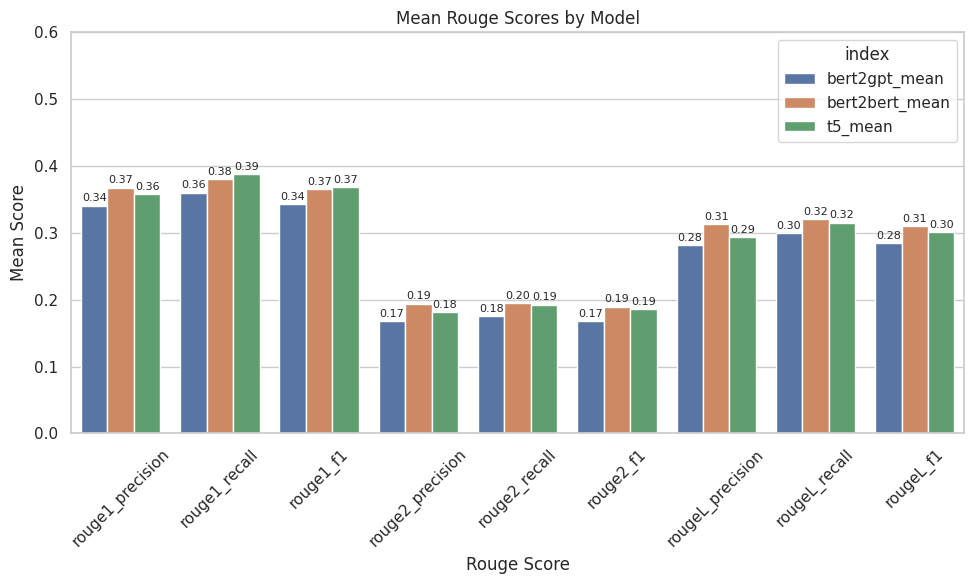

In [ ]:
# Melt the DataFrame to long format for easier plotting
mean_df_long = mean_df.reset_index().melt(id_vars='index', var_name='Rouge', value_name='Score')

# Plot the grouped bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mean_df_long, x='Rouge', y='Score', hue='index')
plt.title('Mean Rouge Scores by Model')
plt.xlabel('Rouge Score')
plt.ylabel('Mean Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0, 0.6)

# Add numbers above the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points',
                fontsize=8)

plt.show()